# CS 4120 - Song Genre Classification

We are compare the performance of Random Forest, K-Nearest Neighbors, Multinomial Naive Bayes, Complement Naive Bayes models, and a Neural Network with LSTM cell for the task of classifying songs by genre.

## Dataset

We use a [Kaggle dataset](https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres?resource=download&select=lyrics-data.csv) with data on many artists and songs originally scraped from Vagalume.com.
Since the dataset associates artists with songs and their lyrics, then genres with artists separately, we join the two datasets in order to make associations between genres and lyrics in order to obtain data to train our models.

## Getting Started

From the Kaggle dataset (linked above), download `artists-data.csv` to `data/artists-data.csv` and `lyrics-data.csv` to `data/lyrics-data.csv`.
Install all the packages imported in the following cell.

In [49]:
%%capture
import pandas as pd
import nltk
import numpy as np
import string
import seaborn as sns
import gensim
from gensim import models

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('words', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Data Preprocessing

In [ ]:
# suppress some warnings in cell output
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
# Import Song Data

song_data = pd.read_csv('./data/lyrics-data.csv')
english_songs = song_data.loc[song_data['language'] == 'en']
english_songs.rename(columns={'ALink':'Link'}, inplace=True)
english_songs.head()

In [ ]:
# Import Artist Data

artist_data = pd.read_csv('./data/artists-data.csv')
artist_data = artist_data.drop_duplicates(subset='Link', keep='first')
artist_data.head()

In [ ]:
# Merge Dataframes

combined_data = pd.merge(english_songs, artist_data, on='Link')
combined_data = combined_data[["SName", "Artist", "Lyric", "Genres"]]
combined_data = combined_data[combined_data.Lyric.notnull()]
combined_data = combined_data[combined_data.Genres.notnull()]
combined_data

In [ ]:
artists = combined_data.Artist.unique()
genres = combined_data.Genres.unique()
labels = ["Blues", "Country", "Hip Hop", "Jazz", "Pop", "Rock"]

In [ ]:
# Randomely select 1000 songs from each genre
SONG_PER_GENRE = 1000

rows = []

for label in labels:
    genre_data = combined_data[combined_data.Genres == label]
    sampled_genre_data = []
    count = 0
    for _, row in genre_data.sample(frac=1).iterrows():
        if len(row.Lyric.strip()) == 0:
            continue
        sampled_genre_data.append(row)
        count += 1
        if count == SONG_PER_GENRE:
            break
    else:
        raise ValueError(f'Not enough songs of genre {label}')
    sampled_genre_data = pd.DataFrame(sampled_genre_data)
    sampled_genre_data.Genres = label
    rows.append(sampled_genre_data)

combined_genre_data = pd.concat(rows).reset_index().drop("index", axis=1)
combined_genre_data

In [ ]:
combined_genre_data.to_csv("combined_genre_data.csv")

## Reload the data

In [2]:
combined_genre_data = pd.read_csv("combined_genre_data.csv")
combined_genre_data.head()

,Unnamed: 0,SName,Artist,Lyric,Genres
0,0,Time Is A Thief,BB King,I woke up this morning and looked at my life\n...,Blues
1,1,I'm Ready,Albert King,"I'm ready, ready as anybody can be\nI'm ready,...",Blues
2,2,Misty Blue,Etta James,"Oh, it's been a long, long time\nLooks like to...",Blues
3,3,Stronger Now In Broken Places,Joe Bonamassa,"You left me, you tore me up\nDidn't know a man...",Blues
4,4,Natchez Burning,Howlin' Wolf,"Did you ever hear about the burning,\nthat hap...",Blues


In [3]:
def train_and_pipeline(lyrics):
    
    # Split the data 75% training and 25% testing
    X_train, X_test, y_train, y_test = train_test_split(lyrics, combined_genre_data.Genres, test_size=0.25) 
    
    pipe_MNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', MultinomialNB())
                       ])
    
    pipe_CNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', ComplementNB())
                       ])

    pipe_RF = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', RandomForestClassifier())
                       ])

    pipe_KNN = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', KNeighborsClassifier())
                       ])

    # List of pipelines, List of pipeline names
    pipelines = [pipe_MNB, pipe_CNB, pipe_RF, pipe_KNN]
    pipeline_names = ['Multinomail NB', 'Complement NB', 'Random Forest', "KNN"]

    # Loop to fit each of the pipelines
    for pipe in pipelines:
        print(pipe)
        pipe.fit(X_train, y_train)

    # Compare accuracies
    lemmed_basic_scores = []
    for index, val in enumerate(pipelines):
        tup = (pipeline_names[index], val.score(X_test, y_test))
        lemmed_basic_scores.append(tup)
        print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))
        
    return lemmed_basic_scores

In [4]:
results = Counter()
lyrics_list = list(combined_genre_data.Lyric)
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
lemmatizer = WordNetLemmatizer()
english = list(set(nltk.corpus.words.words()))
stemmer = SnowballStemmer("english")

# Lemmatization

In [5]:
def clean_docs_lemma(lyrics_list):
    cleaned = []
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_lemmas = [lemmatizer.lemmatize(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_lemmas)
        cleaned.append(c)
    return cleaned

In [6]:
lemmed_lyrics = clean_docs_lemma(lyrics_list)
len(lemmed_lyrics)

6000

In [7]:
lyrics_lengths = [len(lyrics) for lyrics in lemmed_lyrics]

Text(0.5, 6.79999999999999, 'Number of Lyrics')

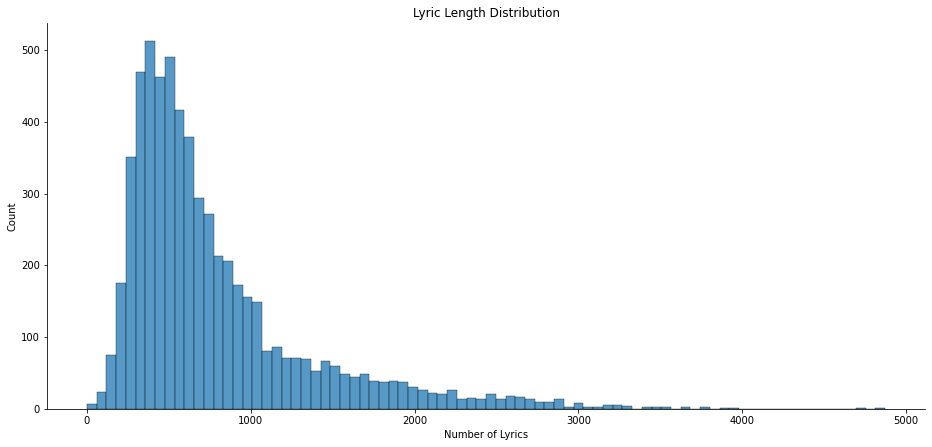

In [8]:
sns.displot(lyrics_lengths)
plt.gcf().set_size_inches(15, 6)
plt.title("Lyric Length Distribution")
plt.xlabel("Number of Lyrics")

In [9]:
results["lemmed"] = train_and_pipeline(lemmed_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.592
Complement NB pipeline test accuracy: 0.588
Random Forest pipeline test accuracy: 0.561
KNN pipeline test accuracy: 0.394


# Stemming

In [10]:
def clean_docs_stemma(lyrics_list):
    cleaned = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_stemmas = [stemmer.stem(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_stemmas)
        cleaned.append(c)
    return cleaned

In [11]:
stemmed_lyrics = clean_docs_stemma(lyrics_list)

In [12]:
results["stemmed"] = train_and_pipeline(stemmed_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.566
Complement NB pipeline test accuracy: 0.568
Random Forest pipeline test accuracy: 0.579
KNN pipeline test accuracy: 0.383


# Stemmed & Lemmatized

In [13]:
lemmatized_stemmed_lyrics = clean_docs_lemma(stemmed_lyrics)

In [14]:
results["lemmatized_stemmed"] = train_and_pipeline(lemmatized_stemmed_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.563
Complement NB pipeline test accuracy: 0.579
Random Forest pipeline test accuracy: 0.593
KNN pipeline test accuracy: 0.393


In [15]:
stemmed_lemmatized_lyrics = clean_docs_lemma(lemmed_lyrics)

In [16]:
results["stemmed_lemmatized"] = train_and_pipeline(stemmed_lemmatized_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.578
Complement NB pipeline test accuracy: 0.594
Random Forest pipeline test accuracy: 0.587
KNN pipeline test accuracy: 0.355


In [17]:
results

Counter({'lemmed': [('Multinomail NB', 0.592),
          ('Complement NB', 0.588),
          ('Random Forest', 0.5613333333333334),
          ('KNN', 0.394)],
         'stemmed': [('Multinomail NB', 0.566),
          ('Complement NB', 0.568),
          ('Random Forest', 0.5786666666666667),
          ('KNN', 0.38266666666666665)],
         'lemmatized_stemmed': [('Multinomail NB', 0.5633333333333334),
          ('Complement NB', 0.5793333333333334),
          ('Random Forest', 0.5926666666666667),
          ('KNN', 0.39266666666666666)],
         'stemmed_lemmatized': [('Multinomail NB', 0.578),
          ('Complement NB', 0.594),
          ('Random Forest', 0.5866666666666667),
          ('KNN', 0.35533333333333333)]})

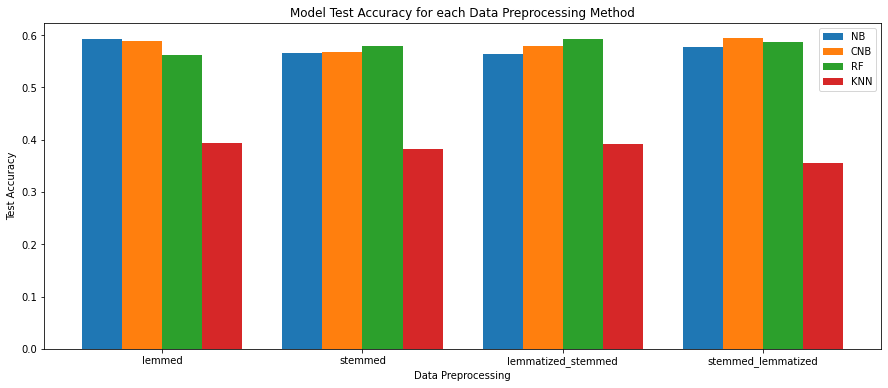

In [18]:
X = results.keys()

MNB = [results[x][0][1] for x in X]
CNB = [results[x][1][1] for x in X]
RF = [results[x][2][1] for x in X]
KNN = [results[x][3][1] for x in X]

X_axis = np.arange(len(X))
plt.bar(X_axis - 0.3, MNB, 0.2, label = 'NB')
plt.bar(X_axis - 0.1, CNB, 0.2, label = 'CNB')
plt.bar(X_axis + 0.1, RF, 0.2, label = 'RF')
plt.bar(X_axis + 0.3, KNN, 0.2, label = 'KNN')

plt.xticks(X_axis, X)

plt.gcf().set_size_inches(15, 6)
plt.xlabel("Data Preprocessing")
plt.ylabel('Test Accuracy')
plt.title("Model Test Accuracy for each Data Preprocessing Method")
plt.legend()
plt.show()

In [19]:
# Based on the results -> 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(lemmed_lyrics, combined_genre_data.Genres, test_size=0.25) 

# Random Forest Classifier

In [21]:
rfc = RandomForestClassifier()

In [30]:
GS_pipe_RF = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', RandomForestClassifier())
                       ])

rf_param_grid = dict(clf__n_estimators = [10, 30, 100, 200],
                  clf__criterion = ['gini', 'entropy'],
                  clf__max_depth = [2, 6, 10, 15], 
                  clf__min_samples_split = [5, 10],
                  clf__min_samples_leaf = [3, 6])


gs_RF = GridSearchCV(estimator=GS_pipe_RF,
            param_grid=rf_param_grid,
            scoring='accuracy',
            cv=3)

gs_RF.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [2, 6, 10, 15],
                         'clf__min_samples_leaf': [3, 6],
                         'clf__min_samples_split': [5, 10],
                         'clf__n_estimators': [10, 30, 100, 200]},
             scoring='accuracy')

In [31]:
rf_gs_testing_score = gs_RF.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(rf_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_RF.best_params_))

Mean Testing Score: 56.0%
Best Parameter Combination Found During Grid Search: 
{'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}


# Multinomial Naive Bayes

In [24]:
GS_pipe_MNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', MultinomialNB())
                       ])

sorted(GS_pipe_MNB.get_params().keys())

mnb_param_grid = dict(clf__alpha = [.01, .05, .1, .2, .4, 1])

gs_MNB = GridSearchCV(estimator=GS_pipe_MNB,
            param_grid=mnb_param_grid,
            scoring='accuracy',
            cv=3)

gs_MNB.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [0.01, 0.05, 0.1, 0.2, 0.4, 1]},
             scoring='accuracy')

In [25]:
mnb_gs_testing_score = gs_MNB.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(mnb_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_MNB.best_params_))

Mean Testing Score: 59.4%
Best Parameter Combination Found During Grid Search: 
{'clf__alpha': 0.1}


# Complement Naive Bayes

In [26]:
GS_pipe_CNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', ComplementNB())
                       ])

sorted(GS_pipe_CNB.get_params().keys())

cnb_param_grid = dict(clf__alpha = [.01, .05, .1, .2, .4, 1])

gs_CNB = GridSearchCV(estimator=GS_pipe_CNB,
            param_grid=cnb_param_grid,
            scoring='accuracy',
            cv=3)

gs_CNB.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                                       ('clf', ComplementNB())]),
             param_grid={'clf__alpha': [0.01, 0.05, 0.1, 0.2, 0.4, 1]},
             scoring='accuracy')

In [27]:
cnb_gs_testing_score = gs_CNB.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(cnb_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_CNB.best_params_))

Mean Testing Score: 58.73%
Best Parameter Combination Found During Grid Search: 
{'clf__alpha': 0.4}


# KNN Classifier

In [28]:
GS_pipe_KNN = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                        ('clf', KNeighborsClassifier())
                        ])

knn_param_grid = dict(clf__n_neighbors = [100, 150, 200],
                     clf__p = [1, 2])

gs_KNN = GridSearchCV(estimator=GS_pipe_KNN,
            param_grid=knn_param_grid,
            scoring='accuracy',
            cv=3)

gs_KNN.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                                       ('clf', KNeighborsClassifier())]),
             param_grid={'clf__n_neighbors': [100, 150, 200], 'clf__p': [1, 2]},
             scoring='accuracy')

In [29]:
knn_gs_testing_score = gs_KNN.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(knn_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_KNN.best_params_))

Mean Testing Score: 45.73%
Best Parameter Combination Found During Grid Search: 
{'clf__n_neighbors': 200, 'clf__p': 2}


# Word Cloud

In [46]:
lemmed_lyrics_tokenized = [nltk.word_tokenize(doc) for doc in lemmed_lyrics]

dictionary = gensim.corpora.Dictionary(lemmed_lyrics_tokenized)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in lemmed_lyrics_tokenized]

0 away
1 could
2 filled
3 grief
4 leave
5 let
6 life
7 little
8 looked
9 mind
10 minute


In [47]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.029*"n't" + 0.020*"love" + 0.014*"ai" + 0.013*"tell" + 0.013*"ca" + 0.012*"like" + 0.011*"get" + 0.010*"time" + 0.009*"got" + 0.008*"go"
Topic: 1 
Words: 0.030*"got" + 0.020*"n't" + 0.019*"ai" + 0.013*"like" + 0.012*"go" + 0.011*"want" + 0.009*"say" + 0.009*"love" + 0.009*"'ll" + 0.008*"baby"
Topic: 2 
Words: 0.052*"love" + 0.016*"heart" + 0.012*"never" + 0.011*"got" + 0.010*"one" + 0.010*"way" + 0.009*"like" + 0.008*"uh" + 0.008*"give" + 0.007*"let"
Topic: 3 
Words: 0.021*"girl" + 0.016*"would" + 0.015*"love" + 0.012*"got" + 0.011*"want" + 0.011*"u" + 0.011*"see" + 0.010*"n't" + 0.010*"take" + 0.008*"ooh"
Topic: 4 
Words: 0.035*"da" + 0.035*"oh" + 0.022*"ba" + 0.019*"love" + 0.016*"got" + 0.014*"like" + 0.011*"na" + 0.011*"n't" + 0.010*"make" + 0.008*"la"
Topic: 5 
Words: 0.028*"oh" + 0.019*"baby" + 0.015*"never" + 0.014*"make" + 0.012*"love" + 0.012*"want" + 0.012*"one" + 0.012*"like" + 0.011*"time" + 0.010*"man"
Topic: 6 
Words: 0.023*"la" + 0.018*"we" + 0.017*"li

In [50]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.005*"love" + 0.004*"baby" + 0.003*"dream" + 0.003*"heart" + 0.003*"like" + 0.003*"way" + 0.003*"oh" + 0.003*"one" + 0.003*"never" + 0.003*"yeah"
Topic: 1 Word: 0.006*"baby" + 0.005*"love" + 0.004*"'ll" + 0.004*"come" + 0.004*"oh" + 0.004*"never" + 0.004*"let" + 0.004*"got" + 0.004*"na" + 0.003*"like"
Topic: 2 Word: 0.005*"baby" + 0.005*"love" + 0.004*"blue" + 0.004*"oh" + 0.003*"one" + 0.003*"na" + 0.003*"'ll" + 0.003*"like" + 0.003*"way" + 0.003*"little"
Topic: 3 Word: 0.005*"oh" + 0.004*"na" + 0.004*"got" + 0.004*"want" + 0.004*"baby" + 0.004*"get" + 0.004*"gon" + 0.003*"love" + 0.003*"need" + 0.003*"like"
Topic: 4 Word: 0.004*"baby" + 0.004*"got" + 0.004*"oh" + 0.004*"love" + 0.004*"n't" + 0.004*"na" + 0.003*"yeah" + 0.003*"let" + 0.003*"get" + 0.003*"like"
Topic: 5 Word: 0.006*"baby" + 0.005*"love" + 0.005*"oh" + 0.004*"'ll" + 0.004*"got" + 0.004*"one" + 0.004*"let" + 0.004*"want" + 0.004*"like" + 0.003*"heart"
Topic: 6 Word: 0.005*"love" + 0.004*"baby" + 0.003*"na

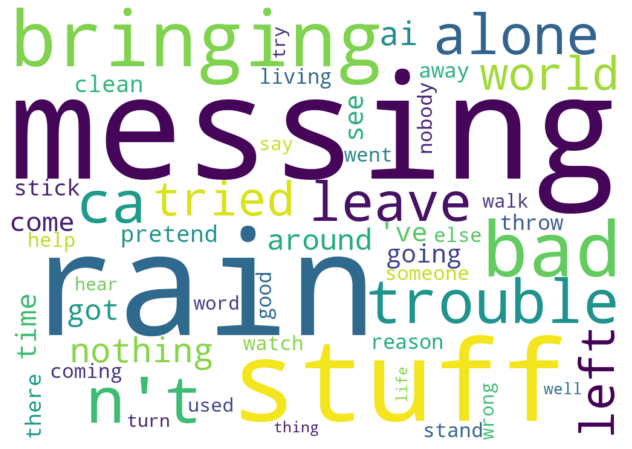

In [51]:
weights = tfidf[bow_corpus[12]]

# Get terms from the dictionary and pair with weights

weights = [(dictionary[pair[0]], pair[1]) for pair in weights]
weights[-35:]
from wordcloud import WordCloud

# Initialize the word cloud

d = {}
for a, x in weights:
    d[a] = x
    
wc = WordCloud(
    background_color="white",
    max_words=2000,
    width = 1024,
    height = 720,
    stopwords=stopwords.words("english")
)

# Generate the cloud

wc.generate_from_frequencies(d)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [52]:
d

{'away': 0.054285517773740806,
 'leave': 0.17229117672902078,
 'life': 0.023747691497785436,
 'see': 0.08709608582765406,
 'time': 0.09627893690169449,
 'ai': 0.136484047066073,
 'good': 0.05072479117009857,
 'got': 0.1074301057169933,
 "n't": 0.21704448764520767,
 "'ve": 0.09286815035692057,
 'ca': 0.20044601123117237,
 'say': 0.03672958211103041,
 'thing': 0.023503265091075167,
 'tried': 0.14857175382336846,
 'turn': 0.035157450916901645,
 'used': 0.03963189302593469,
 'world': 0.14654768818907254,
 'come': 0.09275280715291652,
 'left': 0.1485267346168253,
 'hear': 0.034526806359059296,
 'there': 0.05706670390465156,
 'bad': 0.31580322101885216,
 'else': 0.04603567657942756,
 'someone': 0.041926533811411794,
 'trouble': 0.21322875033223504,
 'nothing': 0.14425540676331167,
 'well': 0.02622798451694175,
 'nobody': 0.04301420984816083,
 'alone': 0.18107882707249978,
 'around': 0.11027310933995133,
 'bringing': 0.32114926047617565,
 'clean': 0.06499185782597229,
 'coming': 0.04735191228